<a href="https://colab.research.google.com/github/lgiesen/forest_height/blob/main/notebooks/PrepareDataForNn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load and prepare data

In [ ]:
!unzip gdrive/My\ Drive/DataDa2/images_train.zip

In [ ]:
!unzip gdrive/My\ Drive/DataDa2/masks_train.zip

In [ ]:
import numpy as np
import pandas as pd
import datetime, os, cv2
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape
from keras.models import Sequential, load_model
from keras.layers import Dense, BatchNormalization, Dropout, InputLayer, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras.callbacks import TensorBoard, ModelCheckpoint

In [ ]:
size = 5 #define window size should be odd so that the label is in the middle
shape = (10, size, size) #define shape of features
labels1 = np.ones(1) #array for labels
data1 = np.ones(shape) #array for features
data1 = np.expand_dims(data1, axis=0) #expand dimension to concatenate
for j in range(20): #iterate over images in directory
  if j < 10:
    X = np.load('/content/images/image_00'+ str(j) + '.npy')
    y = np.load('/content/masks/mask_00'+ str(j) + '.npy')
    indices = np.argwhere(y > 0) #select all values with label
    indices_2d = indices[:, 1:] #extract indices
    ind_y = np.ones(2).reshape(-1,2) #array to collect indices
    for i in indices_2d: #iterate over indices
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape: #select only features with the same shape because of labels at the image border
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1] #save them temporary
        temp2 = np.expand_dims(temp, axis=0) #expand dimension to concatenate
        data1 = np.concatenate((data1, temp2), axis=0) #concatenation

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0) #concatenation of index so that they have the same order and length as the features

    ind_y = ind_y[1:] #remove first dummy values
    indices_1 = ind_y[:, 0].astype(int)
    indices_2 = ind_y[:, 1].astype(int)
    data_y = y[0, indices_1, indices_2] #extract labels
    labels1 = np.concatenate((labels1, data_y), axis = 0) #concatenate labels

  if j >= 10:
    X = np.load('/content/images/image_0'+ str(j) + '.npy')
    y = np.load('/content/masks/mask_0'+ str(j) + '.npy')
    indices = np.argwhere(y > 0)
    indices_2d = indices[:, 1:]
    ind_y = np.ones(2).reshape(-1,2)
    for i in indices_2d:
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape:
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1]
        temp2 = np.expand_dims(temp, axis=0)
        data1 = np.concatenate((data1, temp2), axis=0)

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0)

    ind_y = ind_y[1:]
    indices_1 = ind_y[:, 0].astype(int)
    indices_2 = ind_y[:, 1].astype(int)
    data_y = y[0, indices_1, indices_2]
    labels1 = np.concatenate((labels1, data_y), axis = 0)

data1 = data1[1:] #remove first dummy values
labels1 = labels1[1:] #remove first dummy values

In [ ]:
!unzip gdrive/My\ Drive/DataDa22/images_02.zip #second part of the data

In [ ]:
!unzip gdrive/My\ Drive/DataDa22/masks_02.zip

In [ ]:
shape = (10, size, size)
labels2 = np.ones(1)
data2 = np.ones(shape)
data2 = np.expand_dims(data2, axis=0)
for j in range(20):
  if j < 10:
    X = np.load('/content/images/image_00'+ str(j) + '.npy')
    y = np.load('/content/masks/mask_00'+ str(j) + '.npy')
    indices = np.argwhere(y > 0)
    indices_2d = indices[:, 1:]
    ind_y = np.ones(2).reshape(-1,2)
    for i in indices_2d:
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape:
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1]
        temp2 = np.expand_dims(temp, axis=0)
        data2 = np.concatenate((data2, temp2), axis=0)

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0)

    ind_y = ind_y[1:]
    indices_1 = ind_y[:, 0].astype(int)
    indices_2 = ind_y[:, 1].astype(int)
    data_y = y[0, indices_1, indices_2]
    labels2 = np.concatenate((labels2, data_y), axis = 0)

  if j >= 10:
    X = np.load('/content/images/image_0'+ str(j) + '.npy')
    y = np.load('/content/masks/mask_0'+ str(j) + '.npy')
    indices = np.argwhere(y > 0)
    indices_2d = indices[:, 1:]
    ind_y = np.ones(2).reshape(-1,2)
    for i in indices_2d:
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape:
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1]
        temp2 = np.expand_dims(temp, axis=0)
        data2 = np.concatenate((data2, temp2), axis=0)

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0)

    ind_y = ind_y[1:]
    indices_1 = ind_y[:, 0].astype(int)
    indices_2 = ind_y[:, 1].astype(int)
    data_y = y[0, indices_1, indices_2]
    labels2 = np.concatenate((labels2, data_y), axis = 0)

data2 = data2[1:]
labels2 = labels2[1:]

In [ ]:
features = np.concatenate((data1, data2), axis = 0) #concatenate both parts
labels = np.concatenate((labels1, labels2), axis = 0)

In [ ]:
features[features > 2000] = 2000

In [ ]:
print(features.shape)
print(labels.shape)

In [ ]:
features_mean = np.mean(features, axis=(2, 3)) # patch mean of size * size features
features_mean[features_mean > 2000] = 2000

## Optional: Balance data set

In [ ]:
sample_size = 800

num = (list(range(3, 37, 3))) #create list from 3 to 36 step 3
shape = (10, 5, 5)
data_bal = np.ones(shape) #create array to fill with features
data_bal = np.expand_dims(data_bal, axis=0) #expand one dimension to concatenate
data_lab = np.ones(1) #create array to fill labels
for i in num:
  indices = np.where((labels > i-3) & (labels <= i)) #select indcies from every 3 meter interval until 36
  sampled_indices = np.random.choice(indices[0].flatten(), size=sample_size, replace=False) #random sample of each interval
  tempx = features_mean[sampled_indices]
  tempy = labels[sampled_indices]
  data_bal = np.concatenate((data_bal, tempx), axis=0)
  data_lab = np.concatenate((data_lab, tempy), axis=0)

indices = np.where((labels > 36)) #add the values > 36 m, they are so few no sample needed
sampled_indices = indices[0].flatten()
tempx = features_mean[sampled_indices]
tempy = labels[sampled_indices]
data_bal = np.concatenate((data_bal[1:], tempx), axis=0)
data_lab = np.concatenate((data_lab[1:], tempy), axis=0)

## Train neural network

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features_mean, labels , test_size = 0.3, random_state=3)

In [ ]:
%load_ext tensorboard

In [ ]:
modelNn = Sequential() #build neural network
modelNn.add(Dense(128, input_shape=(10,), kernel_initializer='normal', activation='relu'))
modelNn.add(Dense(256, kernel_initializer='normal', activation='relu'))
modelNn.add(Dense(256, kernel_initializer='normal', activation='relu'))
modelNn.add(Dense(128, kernel_initializer='normal', activation='relu'))
modelNn.add(Dropout(0.4))
modelNn.add(Dense(1, kernel_initializer='normal', activation='linear'))

modelNn.summary()

In [ ]:
modelNn.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_percentage_error']) #compile model

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) #log directory tensorboard
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model_save = ModelCheckpoint("/content/gdrive/MyDrive/NNmodels/best_model3.hdf52", save_best_only = True) #directory best model

modelNn.fit(Xtrain, ytrain, epochs = 100, validation_data=(Xtest, ytest), callbacks=[tensorboard_callback, model_save]) #fit model

## Evaluate results

In [ ]:
bmodel = load_model('/content/gdrive/MyDrive/NNmodels/best_model3.hdf52') #load best model

ypred_nn = bmodel.predict(Xtest)

mse_nn = mse(ytest, ypred_nn)

rmse_nn = mse_nn ** (1/2)

mae_nn = mae(ytest, ypred_nn)

mape_nn = mape(ytest, ypred_nn)

print(mape_nn)

print(mae_nn)

print(rmse_nn)

362/362 [==============================] - 1s 3ms/step
0.49005475065971976
4.430073310357477
7.320163610567323


In [ ]:
%tensorboard --logdir logs

In [ ]:
mean_nn = np.mean(ypred_nn[:])
quantiles_nn = np.percentile(ypred_nn[:], [1, 25, 50, 75, 99])

mean_labels = np.mean(labels[:])
quantiles_labels = np.percentile(labels[:], [1, 25, 50, 75, 99])

print(mean_nn)
print(quantiles_nn)

print(mean_labels)
print(quantiles_labels)

10.956826
[ 2.73446094  2.91855043  4.37046814 20.95750618 29.33050219]
11.88373569284665
[ 2.3900001   2.8599999   5.6500001  20.79999924 39.44700012]


In [ ]:
print(np.sort(ypred_nn.flatten())[:10])
print(np.sort(ypred_nn.flatten())[-10:][::-1])

print(np.sort(labels.flatten())[:10])
print(np.sort(labels.flatten())[-10:][::-1])

[2.017904  2.1737761 2.264671  2.298547  2.2986226 2.300339  2.3026571
 2.3038893 2.3045855 2.307034 ]
[35.02316  34.5017   32.861572 32.448227 32.238266 32.12586  32.112335
 31.829458 31.584995 31.407364]
[1.34000003 1.57000005 1.75       1.83000004 1.89999998 1.89999998
 1.94000006 1.98000002 2.16000009 2.17000008]
[81.69000244 69.97000122 62.13000107 58.63000107 57.93000031 57.56000137
 55.20000076 54.56000137 54.11999893 54.04999924]


## Predict test image

In [28]:
Xs = np.load('/content/gdrive/MyDrive/TestData/private_test_image_reduced.npy') #load test image

In [ ]:
patch_size = 1024 #define patch size
ind = 0 #index for saved oatch images

for i in range(4):
  for j in range(4):
    temp = Xs[:,i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
    np.save('/content/gdrive/MyDrive/TestPatches/patch_'+ str(ind) + '.npy', temp)
    ind = ind + 1


In [ ]:
folder_path = '/content/gdrive/MyDrive/TestPatches/'  #folder path
nnmodel = load_model('/content/gdrive/MyDrive/NNmodels/best_model3.hdf52')
ind = 0

# Iterate over the files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
      X = np.load(file_path)
      X[X > 2000] = 2000
      Xr = X.reshape(10,-1).transpose()
      nnpred = nnmodel.predict(Xr)
      nnpredr = nnpred.transpose().reshape(1,1024,1024)
      np.save('/content/gdrive/MyDrive/MaskNN/mask_'+ str(ind) + '.npy', nnpredr)
      ind = ind + 1
      print(np.percentile(nnpred[:], [1, 25, 50, 75, 99]))
      print(np.sort(nnpred.flatten())[:10])
      print(np.sort(nnpred.flatten())[-10:][::-1])






In [42]:
folder_path = '/content/gdrive/MyDrive/MaskNN/'  #folder path
img_list = []

# Iterate over the files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        # Load the data from the file
        data = np.load(file_path)
        # Append the data to the list
        img_list.append(data)
# Concatenate the patches along the columns (horizontal axis)
im1 = np.concatenate((img_list[0], img_list[1], img_list[2], img_list[3]), axis=2)
im2 = np.concatenate((img_list[4], img_list[5], img_list[6], img_list[7]), axis=2)
im3= np.concatenate((img_list[8], img_list[9], img_list[10], img_list[11]), axis=2)
im4 = np.concatenate((img_list[12], img_list[13], img_list[14], img_list[15]), axis=2)

# Concatenate the rows along the vertical axis to rebuild the original image
original_image = np.concatenate((im1, im2, im3, im4), axis=1)


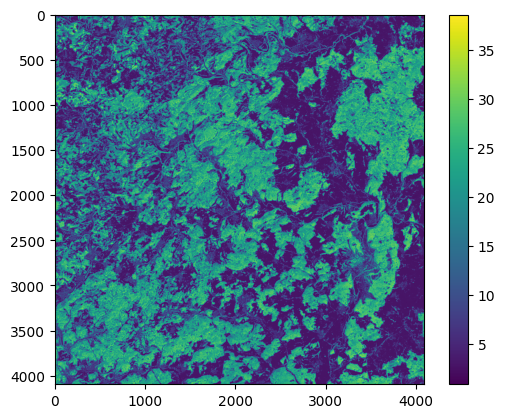

In [43]:
tree_height_2d = original_image[0]

# Plot the tree height data
plt.imshow(tree_height_2d, cmap='viridis')

# Add colorbar for reference
plt.colorbar()

# Display the plot
plt.show()

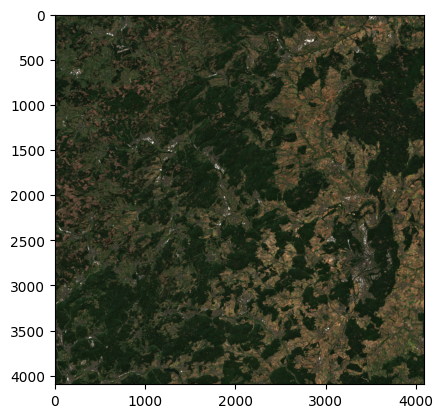

In [44]:
plt.imshow(Xs[[2,1,0]].transpose(1,2,0)/3000)